# GREED MODE 

For the project we choose to build a brand new game mode that can be played in NetHack, the Greed Mode.  
In this challenge the agent has to pass 5 levels with the highest amount of money and the highest amount of health.  
In every floor it has to pass trough a shop phase, where he can buy items to face the next phase, the battlefield.  
The battlefield is a challenge where it can find enemies, depending on the level, and gold, the currency of the shop, that can be used in the next floor to buy better items and so on.
To evaluate the performance of the agent we choose three measures:  
  
Healtiness: evaluates the remaining health point, those can be restored by the healing potion or they can be permanently increased buying the armors in the shop. Better armor -> More maximum Healtiness -> More resistance to the enemies  
  
Richness: evaluates the remaining money, a strong agent doesen't need to buy everytime the best items to pass the level.  
  
Level Reached: the run can't always go as expected and sometimes the agent will fail before completing the last level.  
  
  
In order to play this game mode we had to build the new enviroment starting from zero because of the poor customization offered for the standard Nethack shop. So we will generate randomly the two part of the level (shop and battlefield) then we will merge them in a unique des file that can be used as a valid level for the simulations throught the gym libraries.

 

# LEVEL GENERATION

In [102]:
import gym
import minihack
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import sys
from io import StringIO
from minihack import LevelGenerator
from minihack.envs.room import MiniHackRoom15x15
from minihack.envs.corridor import MiniHackCorridor
from minihack.envs.mazewalk import MiniHackMazeWalk9x9


In [103]:
def render_des_file(des_file):

    env = gym.make('MiniHack-Skill-Custom-v0',
               character="sam-hum-neu-mal",
               observation_keys=('screen_descriptions','inv_strs','blstats','message','pixel'),
               des_file=des_file)

    obs = env.reset()
    env.render()
    plt.imshow(obs['pixel'][0:1000, 0:1000])

## SHOP GENERATION

Now we define the function that creates the store des files, the map is default but the items are randomly generated with this logic:  
  
-A Healing Item (healing potion) is always present.  
-Two to five items are present on the right, these are always different (sword and bow, bow and armor, sword and armor, sword and best sword)  
-The cost of the items depends on the others respecting this scale : potion->weapon->armor->better weapon ->better armor  
-The weapon will change the character's attack by making more enemies beatable, the armor will increase the maximum healthiness, the potion will cure the healthiness without exceeding the limit.  
  
-Available items are:  
'healing' (life potion)  
'weapon' (close range)  
'armor' (increasing resistance)  
      
-Available swords are :  
 'orcish dagger'
 'stiletto'  
 'long sword'  
 'morning star'  
 'katana' 
 'tsurugi 

  
-The possible armors are :  
 'scale mail'  
 'bronze plate mail'  
 'dwarvish mithril-coat'  
 'elven mithril-coat'  
 'chain mail'  
 'splint mail'
  
All items are ordered from weakest to strongest.

In [104]:
AVAIABLE_ITEMS=[
'healing',
]

#Avaiable weapons from the weakest to the strongest

AVAIABLE_WEAPONS=[
'orcish dagger', #Level 1
'stiletto', #Level 2
'long sword', #Level 3
'morning star', #Level 4
'katana', #Level 5
'tsurugi'#Level 5 (bonus)
]

AVAIABLE_ARMORS=[
'scale mail', 
'bronze plate mail', 
'dwarvish mithril-coat',
'elven mithril-coat',
'chain mail',
'splint mail'  
]

SYMBOLS=[
'!', #healing potion
')', #weapons
'[', #armor
]

avaiableitems=['HEALING','WEAPON','ARMOR']


We define the function that adds a random object (dependent on the seed entered) to the given location.  
-In higher levels better weapons are spawned.  
-The items type offered are equal but with more quality if all items are already spawned (in four and five case)  
-All the items in the shop can be purchased picking them up and updating the Knowledge base (for the poor customization offered for the standard shop)



In [105]:
def addobject(lvl: LevelGenerator, seed:int, posx:int ,posy:int,others: [str]) ->str:
    """
    lvl is the Level Generator object, where we have to add items.
    seed is the starting number for the level generation, it has to be included in a range from 0 to 200.
    posx and posy are the coordinates for the item to spawn in the shop, it depends from the avaiable quantity.
    others is the list of the name of the others item already spawned.
    addobject returns the name of the spawned item, useful to update the others list mentioned before. 
    """
    #For the shop we use seeds that are multiple of the original seed
    levelnumber =math.floor(seed/200)
    quality=levelnumber-1
    remainingitems=['HEALING','WEAPON','ARMOR']
    #If the shop has 5 items there is an item from a highest quality, or lowest inthe level 5 case, we refresh the array with the remaining avaible items.
    
    for i in others:
        remainingitems.pop(remainingitems.index(i))
        if remainingitems.__len__()==0:
            remainingitems=['HEALING','WEAPON','ARMOR']
            quality=quality+1

    choice=seed%remainingitems.__len__()
    choosen=remainingitems[choice]
    pos=(posx,posy)

    if choosen=='HEALING':
        choosenitem=AVAIABLE_ITEMS[0]
        choosensymbol=SYMBOLS[0]
        lvl.add_object(name=choosenitem,symbol=choosensymbol,place=pos)

    elif choosen=='WEAPON':
        choosenitem=AVAIABLE_WEAPONS[quality]
        choosensymbol=SYMBOLS[1]
        lvl.add_object(name=choosenitem,symbol=choosensymbol,place=pos)

    else:
        choosenitem=AVAIABLE_ARMORS[quality]
        choosensymbol=SYMBOLS[2]
        lvl.add_object(name=choosenitem,symbol=choosensymbol,place=pos)
        
    return choosen

Now we define the funcion that fills the shop with a number of items depending on the level:  
Level 1: 3 (80%), 4 (15%) 5 (5%)  
Level 2: 3 (50%), 4 (40%) 5 (10%)  
Level 3: 3 (30%), 4 (50%) 5 (20%)  
Level 4: 3 (20%), 4 (30%) 5 (50%)  
Level 5: 3 (5%), 4 (15%) 5 (80%)  
We choose to increase probability towards the level because the enemies become harder and better items can be useful to reach the end.


In [106]:

def fillwithobj(lvl: LevelGenerator,seed: int, levelnumber:int):
    random.seed(seed)
    numitem=random.randint(3,5) 
    if levelnumber==1:
        if seed<=60:
            numitem=3
        elif seed<=190:
            numitem=4
        else: 
            numitem=5

    elif levelnumber==2:
        if seed<=100:
            numitem=3
        elif seed<=180:
            numitem=4
        else: 
            numitem=5

    elif levelnumber==3:
        if seed<=60:
            numitem=3
        elif seed<=160:
            numitem=4
        else: 
            numitem=5

    elif levelnumber==4:
        if seed<=40:
            numitem=3
        elif seed<=100:
            numitem=4
        else: 
            numitem=5

    elif levelnumber==5:
        if seed<=10:
            numitem=3
        elif seed<=40:
            numitem=4
        else: 
            numitem=5

    others=[]
     
    #In the first level a healing potion is guaranteed, the other choices are pseudo-random (depending on the seed)  
    if numitem==3:
        if levelnumber==1:
            others=['HEALING']
            lvl.add_object(name='healing',symbol='!',place=(4,3))
        else:
            others.append(addobject(lvl,seed,4,3,others))
        others.append(addobject(lvl,seed,6,3,others))
        others.append(addobject(lvl,seed,8,3,others))

    elif numitem==4:
        if levelnumber==1:
            others=['HEALING']
            lvl.add_object(name='healing',symbol='!',place=(3,3))
        else:
            others.append(addobject(lvl,seed,3,3,others))
        others.append(addobject(lvl,seed,5,3,others))
        others.append(addobject(lvl,seed,7,3,others))
        others.append(addobject(lvl,seed,9,3,others))

    elif numitem==5:
        if levelnumber==1:
            others=['HEALING']
            lvl.add_object(name='healing',symbol='!',place=(2,3))
        else:
            others.append(addobject(lvl,seed,2,3,others))
        others.append(addobject(lvl,seed,4,3,others))
        others.append(addobject(lvl,seed,6,3,others))
        others.append(addobject(lvl,seed,8,3,others))
        others.append(addobject(lvl,seed,10,3,others))






Finally we define the function that creates the store des file and displays it on the screen.  
The levelnumber is used to generate levels dependent on the floor the character has reached, higher floors->better items in the shop and more possible choices (increased probability).  
The shopkeeper has been removed in the last version because is an unpredictable monster and we want a more manageable enviroment to work with.  
Once the purchases are don the agent can pick up the Skeleton Keys placed in front of the exit (we put two of the because they can break) and open the way to the battlefield area.  
The seed must be choosen from 1 to 200 and the levelnumber must be from 1 to 5.


Konnichi wa Agent, welcome to NetHack!  You are a lawful male human Samurai.    
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                              ----------------                                  
                              |..........(+...                                  
                              |..........(|---                                  
                              |.[.).!.[.).|                                     
                           

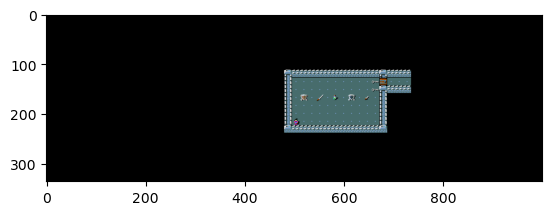

In [107]:

def createshop(levelnumber: int,startingseed: int):
    map="""||||||||||||||||
|...............
|...........||||
|...........|    
|...........|    
|...........|   
|...........|     
|||||||||||||"""
    seed=startingseed
    lvl=LevelGenerator(map=map,lit=True,flags=['premapped','shortsighted'])
    lvl.add_line("#LEVEL: "+str(levelnumber))
    lvl.add_line("#SEED: "+str(seed))
    lvl.set_start_pos((1,6))
    #lvl.add_monster(name='shopkeeper',place=(6,1))
    lvl.add_object(name='skeleton key',symbol='(',place=(11,1)) #Skeleton Key
    lvl.add_object(name='skeleton key',symbol='(',place=(11,2))

    lvl.add_door("locked", place=(12,1))

    
    fillwithobj(lvl,seed,levelnumber)

    

    return lvl.get_des()

seed=random.randint(1,200)
level=random.randint(1,5)
render_des_file(createshop(level,seed))

## BATTLEFIELD GENERATION

In this section we show how we generate the battlefield, the area where our agent will find gold and monsters to defend it.
For the battlefield we chose 5 possible maps for each level with a random generation of monsters and coins.
In each possible level it can happen:  
-Boss room, where there will be only one enemy, the strongest for that level that will defend so many coins.  
-Maze room, the agent will have to perform pathfinding to find the exit and the gold, randomly scattered within the level  
-Room, an open room with enemies and coins  
-Mini boss room: the room shown during the presentation, minibosses defending lots of gold, enemies defending the exit and more enemies defending the gold  
-BONUS ROOM: a very rare room, (1/100) where only coins will be present,  
Next we define the complete list of monsters, in ascending order by difficulty.


In [118]:
MOB=['newt', #Level 1
     'iguana',   #Level 2
     'giant ant',   #Level 3
     'lemure']  #Level 4

MINIBOSS=['paper golem',  #Level 2
          'dog', #Level 3
          'lizard'] #Level 4

BOSS=['rock mole', #Level 2 
      'jellyfish', #Level 3 
      'giant beetle', #Level 4
        'yeti']  #Level 5


In [109]:
minibossmap="""                    ||||||||||||
                    |..........|
                    |.||||||...|
                    |.|........|
                    |.|||||....|
                    |.....|....|
                    |||||||....|
                    |..........|
                    |.|||||....|
                    |.|...|....|
                    |.|...|....|
                    ..|...|....|
                    |||.||||...|
                    |......|...|
                    |......|...|
                    |..........|
                    |......|...|
                    ||||||||||||"""




bossmap="""                          |||||      
                          |...|      
                          |...|      
                    ||||||||.||||    
                    |...|.......|    
                    |...|.......|||||
                    |...|.......|...|
                    ................|
                    |...|.......|...|
                    |...|.......|||||
                    |...|.......|    
                    |||||||||||||"""    


roommap="""                    |||||||||||||||
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    |.............|
                    ..............|
                    |||||||||||||||"""

mazebasemap="""                    |||||||||||||||||||||||||
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    ..                     .|
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    |.                     .|
                    |||||||||||||||||||||||||"""

bonusroommap="""                    |||||||
                    |.....|
                    ......|
                    |.....|
                    |||||||
                    
                    
                    
                    
                    
                    """



Bonus room: small room with 15 gold that can be taken without any difficulty.

In [110]:
def bonusroom()->str:
    lvl=LevelGenerator(lit=True,flags=['premapped'],map=bonusroommap)
    lvl.set_start_pos((21,2))
    lvl.add_stair_down(place=(24,1))
    lvl.add_line("GOLD: 5,(22,2)")
    lvl.add_line("GOLD: 5,(23,2)")
    lvl.add_line("GOLD: 5,(24,2)")
    
    return lvl.get_des()


Boss room: a room with a boss and 20 gold of reward for its death.


Konnichi wa Agent, welcome to NetHack!  You are a lawful male human Samurai.    
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                              -----                             
                                              |.>.|                             
                                              |...|                             
                                        --------.----                           
                                        |...|.......|                           
                                        |...|.......|----                       
                           

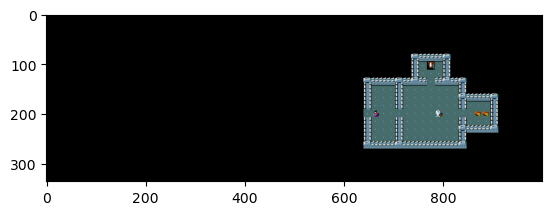

In [119]:
def bossroomdes(levelnumber: int)->str:
    lvl=LevelGenerator(map=bossmap,lit=True,flags=['premapped'])
    lvl.set_start_pos((21,7))
    lvl.add_stair_down(place=(28, 1))
    lvl.add_line("GOLD: 5,(34,7)")
    lvl.add_line("GOLD: 5,(35,6)")
    lvl.add_line("GOLD: 5,(35,7)")
    lvl.add_line("GOLD: 5,(35,8)")
    lvl.add_monster(name=BOSS[levelnumber-2],place=(29,7))
    
    return lvl.get_des()

render_des_file(bossroomdes(2))
render_des_file(bossroomdes(3))
render_des_file(bossroomdes(4))
render_des_file(bossroomdes(5))

Mini boss room: the room shown in the presentation, three Mobs defend the exit, one defends 5 gold and a Miniboss defends 15 gold.


Konnichi wa Agent, welcome to NetHack!  You are a lawful male human Samurai.    
                                                                                
                                                                                
                                                                                
                                            ------------                        
                                            |.........>|                        
                                            |.------...|                        
                                            |.|........|                        
                                            |.-----....|                        
                                            |.....|....|                        
                                            |------....|                        
                                            |..........|                        
                           

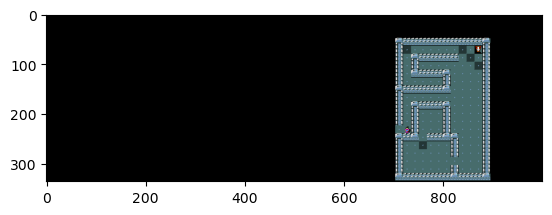

In [112]:
def minibossroomdes(levelnumber: int)->str:
    lvl=LevelGenerator(map=minibossmap,lit=True,flags=['premapped'])
    lvl.set_start_pos((21,11))
    lvl.add_stair_down(place=(30, 1))
    
    #MOB ZONE
    lvl.add_monster(name=MOB[levelnumber-1],place=(28,1))
    lvl.add_monster(name=MOB[levelnumber-1],place=(29,2))
    lvl.add_monster(name=MOB[levelnumber-1],place=(30,3))

    #MOB ZONE (optional)
    lvl.add_monster(name=MOB[levelnumber-1],place=(21,1))
    #MOB REWARD
    lvl.add_line("GOLD: 5,(25,5)")

    #MINIBOSS ZONE (optional)
    lvl.add_monster(name=MINIBOSS[levelnumber-2],place=(23,13))
    #MINIBOSS REWARD
    lvl.add_line("GOLD: 5,(23,10)")
    lvl.add_line("GOLD: 5,(24,10)")
    lvl.add_line("GOLD: 5,(25,10)")

    return lvl.get_des()

render_des_file(minibossroomdes(2))
render_des_file(minibossroomdes(3))
render_des_file(minibossroomdes(4))


Common room: room without obstacles, Mob and gold are randomly distributed.


Konnichi wa Agent, welcome to NetHack!  You are a lawful male human Samurai.    
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                          ---------------                       
                                          |..........:.>|                       
                                          |.........:...|                       
                                          |..$..........|                       
                                          |.........:...|                       
                                          |.............|                       
                           

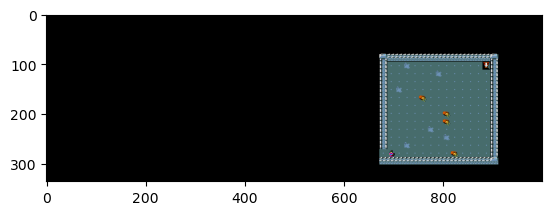

In [121]:
def roomroomdes(seed: int,levelnumber : int)->str:
    lvl=LevelGenerator(map=roommap,lit=True,flags=['premapped'])
    lvl.set_start_pos((21,12))
    lvl.add_stair_down(place=(33, 1))
    random.seed(seed)

    #MUTUALLY EXCLUSIVE RANDOMNESS----
    pseudoarray=[]
    for i in range(1,13):
        pseudoarray.append(i)
    pseudomatrix=[]
    for i in range(0,10):
        pseudomatrix.append(pseudoarray)
    temporaryseed=seed
    def pseudorandompos (seed:(int))->(int,int):
        random.seed(seed)
        a=random.randint(0,9)
        b=random.choice(pseudomatrix[a])
        pseudomatrix[a].pop(pseudomatrix[a].index(b))
        return (a+22,b)
    #---------------------------------    

    for i in range(0,4):
        lvl.add_line("GOLD: 5,"+str(pseudorandompos(temporaryseed)))
        temporaryseed=temporaryseed+1

    for i in range(0,6):
        lvl.add_monster(name=MOB[levelnumber-1],place=pseudorandompos(temporaryseed))
        temporaryseed=temporaryseed+1
  
    return lvl.get_des()
render_des_file(roomroomdes(random.randint(1,200),1))
render_des_file(roomroomdes(random.randint(1,200),2))
render_des_file(roomroomdes(random.randint(1,200),3))
render_des_file(roomroomdes(random.randint(1,200),4))




Maze Room: Pathfinding in a small Labirinth with three Mobs in movement randomly. At the end of the level there are 15 gold as reward.


Konnichi wa Agent, welcome to NetHack!  You are a lawful male human Samurai.    
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                    ---                   ---                   
                                    |.                     .|                   
                                    |.......................|                   
                                    |.          . .       ..|                   
                                    .@..... ... . . ..... .>|                   
                                    |.    . . .   . .   . ..|                   
                           

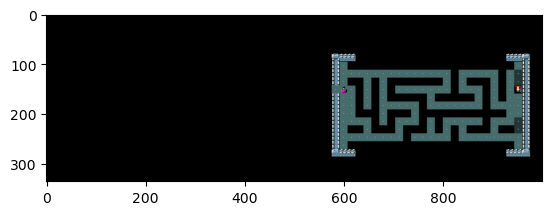

In [114]:
def mazeroomdes(levelnumber:int )->str:
    lvl=LevelGenerator(map=mazebasemap,lit=True,flags=['premapped'])
    lvl.set_start_pos((21,4))

    lvl.add_stair_down(place=(43, 4))
    
    lvl.add_mazewalk(coord=(21,4), dir='east')

    lvl.add_monster(MOB[levelnumber-1],place=(43,3))
    lvl.add_monster(MOB[levelnumber-1],place=(43,2))
    lvl.add_monster(MOB[levelnumber-1],place=(43,8))
    lvl.add_monster(MOB[levelnumber-1],place=(43,9))

    lvl.add_line("GOLD: 5,(43,5)")
    lvl.add_line("GOLD: 5,(43,6)")
    lvl.add_line("GOLD: 5,(43,7)")
 
    return lvl.get_des()


render_des_file(mazeroomdes(2))
render_des_file(mazeroomdes(3))
render_des_file(mazeroomdes(4))


  
Common Room = 50% | Miniboss Room = 30% | Boss Room = 10% | Maze Room = 9,5% | Bonus Room=0,5%  
In the first level is guaranteed a Room, in the last a Boss Room, for the others the previous probabilities are followed. 



In [115]:
def createbattlefield(levelnumber:int ,startingseed:int )->(str,str):
    if levelnumber==1:
        return roomroomdes(startingseed, levelnumber),"roomroom"
    elif levelnumber==5:
        return bossroomdes(5),"bossroom"
    else:
        random.seed(startingseed*levelnumber)
        choice=random.randint(0,200)
        if(choice<=100):
            return (roomroomdes(startingseed,levelnumber),"roomroom")
        elif(choice<=160):
            return (minibossroomdes(levelnumber),"minibossroom")
        elif(choice<=180):
            return (bossroomdes(levelnumber),"bossroom")
        elif(choice<=199):
            return (mazeroomdes(levelnumber),"mazeroom")
        else:
            return (bonusroom(),"bonusroom")

    
createbattlefield(1,1)

('\nMAZE: "mylevel", \' \'\nFLAGS:premapped\nINIT_MAP: solidfill,\' \'\nGEOMETRY:center,center\nMAP\n                    |||||||||||||||\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    |.............|\n                    ..............|\n                    |||||||||||||||\nENDMAP\nREGION:(0,0,35,14),lit,"ordinary"\nBRANCH:(21,12,21,12),(20,11,20,11)\nSTAIR:(33, 1),down\nGOLD: 5,(24, 10)\nGOLD: 5,(22, 2)\nGOLD: 5,(25, 12)\nGOLD: 5,(25, 6)\nMONSTER:"newt",(31, 7)\nMONSTER:"newt",(31, 11)\nMONSTER:"newt",(27, 3)\nMONSTER:"newt",(25, 5)\nMONSTER:"newt",(29, 8)\nMONSTER:"newt",(31, 1)\n',
 'roomroom')

In the last part of the level generation notebook we are going to merge the generated shop, to the generated battlefield to obtain the des file of the completed level.  
The required arguments are the level number and a seed.

In [116]:

def takemap(desfile: str):
    dessplittato=desfile.split('\n')
    j=0
    for i in dessplittato:
        if i=="MAP":
            break
        else:
            j=j+1
    dessplittato=dessplittato[j+1:]
    l=0
    for k in dessplittato:
        if k=="ENDMAP":
            break
        else:
            l=l+1
    dessplittato=dessplittato[:l]
    return '\n'.join(dessplittato)

def mapmerger(shopmap:str,bfdmap:str):
    cleanbfd=(bfdmap)
    cleanbfdlist=cleanbfd.split('\n')
    cleanlines=[]
    for i in cleanbfdlist:
        cleanlines.append(i[18:])
    cleanshop=(shopmap)
    cleanshoplist=cleanshop.split('\n')
    cleanlen=cleanshoplist.__len__()
    finalmap=[]
    k=0
    for j in cleanlines:
        if k<cleanlen:
            finalmap.append(cleanshoplist[k]+j)
        else:
            finalmap.append("                  "+j)
        k=k+1
    cleanlines=[]
    return('\n'.join(finalmap))


print(mapmerger(takemap(createshop(1,1)),takemap(bonusroom())))
print('\n\n\n')
print(mapmerger(takemap(createshop(2,2)),takemap(bossroomdes(2))))
print('\n\n\n')
print(mapmerger(takemap(createshop(3,2)),takemap(minibossroomdes(3))))
print('\n\n\n')
print(mapmerger(takemap(createshop(4,2)),takemap(roomroomdes(2,4))))
print('\n\n\n')
print(mapmerger(takemap(createshop(4,2)),takemap(roomroomdes(2,4))))

||||||||||||||||    |||||||
|...............    |.....|
|...........||||    ......|
|...........|       |.....|
|...........|       |||||||
|...........|              
|...........|              
|||||||||||||              
                           
                           
                           




||||||||||||||||          |||||      
|...............          |...|      
|...........||||          |...|      
|...........|       ||||||||.||||    
|...........|       |...|.......|    
|...........|       |...|.......|||||
|...........|       |...|.......|...|
|||||||||||||       ................|
                    |...|.......|...|
                    |...|.......|||||
                    |...|.......|    
                    |||||||||||||    




||||||||||||||||    ||||||||||||
|...............    |..........|
|...........||||    |.||||||...|
|...........|       |.|........|
|...........|       |.|||||....|
|...........|       |.....|....|
|...........|       |||||||...

After we've generated the two parts we take the merging points (exit of the shop and spawn point of the battlefield), then we merge them thanks to a simple corridor where both of the ends are locked with two doors (the keys are always avaiable for free in the shop).


Konnichi wa Agent, welcome to NetHack!  You are a lawful male human Samurai.    
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                    ----------------          -----                             
                    |".........(+...          |.>.|                             
                    |..........(|--.          |...|                             
                    |...).!.[...|  .    --------.----                           
                    |...........|  .    |...|.......|                           
                    |...........|  .    |...|.......|----                       
                    |@.....

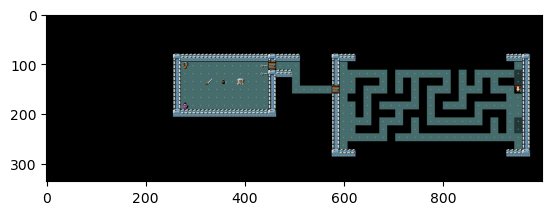

In [117]:

def incomingextractor(bfddes:str)->(str,(int,int)):
    bfdsplitted=bfddes.split('\n')
    for i in bfdsplitted:
        if "BRANCH" in i:
            branchsplittato=(i[7:].split(','))
            portalx=branchsplittato[2]
            portaly=branchsplittato[1]
            bfdsplitted.pop(bfdsplitted.index(i))
            return(('\n'.join(bfdsplitted)),(int(portalx)-1,int(portaly)))

def headerextractor(desfile:str): 
    dessplitted=desfile.split('\n')
    k=0
    for j in dessplitted:
        if "ENDMAP" in j:
            break
        else:
            k=k+1
    finale="\n".join(dessplitted[k+1:])
    return finale


#completemapdes returns the des file of the completed level with shop and battlefield merged in a unique level, they are connected by a simple corridor and separated by two locked door that can be unlocked by the skeleton keys in the shop.
def completemapdes(levelnumber,startingseed,custom=None):
    if custom==None:
        battlefield,custom=createbattlefield(levelnumber,startingseed)
    elif custom=="boss":
        battlefield=bossroomdes(levelnumber)
    elif custom=="miniboss":
        battlefield=minibossroomdes(levelnumber)
    elif custom=="room":
        battlefield=roomroomdes(startingseed,levelnumber)
    elif custom=="maze":
        battlefield=mazeroomdes(levelnumber)
    elif custom=="bonus":
        battlefield=bonusroom()
    else:
        print("choosen a wrong custom map")
        return None

    portal=incomingextractor(battlefield)
    battlefield=portal[0]
    incominglocation=portal[1]
    
    battlefieldheader=headerextractor(battlefield)
    shop=createshop(levelnumber,startingseed)
    shopheader=headerextractor(shop)
    lvl=LevelGenerator(map=mapmerger(takemap(shop),takemap(battlefield)),lit=True,flags=['premapped','shortsighted'])
    lvl.add_line(shopheader)
    lvl.add_object(name="amulet of ESP",symbol="\"",place=(1,1))
    lvl.add_line(battlefieldheader)
    lvl.add_door("locked", place=incominglocation)
    lvl.fill_terrain("rect",".",15,1,15,incominglocation[1])
    lvl.fill_terrain("rect",".",15,incominglocation[1],incominglocation[0]-1,incominglocation[1])
    return lvl.get_des(),custom




render_des_file(completemapdes(3,28,"boss")[0])
render_des_file(completemapdes(3,28,"miniboss")[0])

render_des_file(completemapdes(3,28,"bonus")[0])
render_des_file(completemapdes(3,28,"room")[0])
render_des_file(completemapdes(3,28,"maze")[0])



IN ORDER TO CREATE A NEW VALID DES CALL: completemapdes(1,20)
IF A SPECIFIC TYPE OF LEVEL IS REQUIRED ADD THE ARGUMENT ("room","maze","boss","miniboss","bonus") AS THE LAST ARGUMENT.
